# Additive Models in Python

This notebook walks through the process of creating additive models for time-series data in Python. In particular, we use the Facebook Prophet package and financial data from quandl. 

If you do not already have the quandl package installed then enter the following package
into your terminal:

https://www.quandl.com/

In [27]:
!pip install quandl

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# quandly for financial data
import quandl
# pandas for data manipulation
import pandas as pd

C:\Users\notre\Anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [3]:
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# What is Time Series?
Times series are one of the most common data types encountered by people every day. Some examples for the use of this data includes forecasting weather, stock prices, or a specific variable over time. 

In this notebook, we use a simple model called the additive model to predict this data. This model will represent a combination of patterns different scales, whether it be daily, weekly, seasonally, or yearly. 

For example, if we performed year over year analyses for a big retailer, such as Macy's, we may see that there is usually a spike in purchases around late fall. This could tell the retailer that their sales have spiked from the holiday season or the increase in purchasing of winter clothes. The retailer would then be able to to perform deeper analyses in order to help them forecast inventory levels. 

# Retrieve Data from Quandl

We will explore the market capitalization of two American car companies, GM and Tesla. Quandl is a package that allows us to get this clean financial data without having to spend time cleaning it.

(If you would like to use other companies besides Tesla and GM, you can just replace the stock tickers with those of your choice)

In [4]:
# this is my specific key from my quandl account - you can make your own for free if you'd like
quandl.ApiConfig.api_key = '*'

# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')

# Retrieve the GM data from Quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


### Quick Visualization of the Data

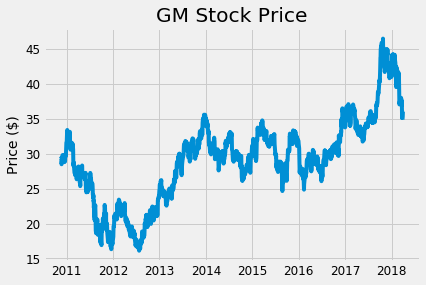

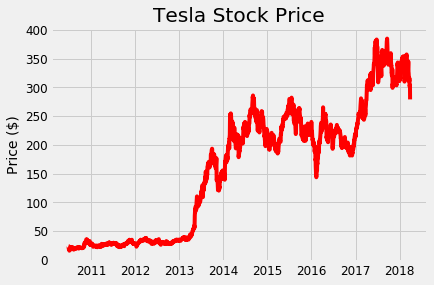

In [5]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

We cannot compare the two companies just on their stock prices,
but instead we must compare them using market capitalization. 

market capitalization = (avg shares outstanding) x (share price)

We must use the share price from each year to determine this. 

In [6]:
# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 
                2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}

gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 
                2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010: 1.50e9}

#### Calculate Market Capitalization
We will create two columns that are specifically for the market cap of each company.

We will then merge the columns so we can compare the market cap of both companies on the same dates. Then we will select the date, gm, and tesla columns so we can compare. After this, we will perform a calculation to get the market cap in billions. 

In [7]:
# Create a year column 
tesla['Year'] = tesla.index.year

# Take Dates from index and move to Date column 
tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    
    # Update the cap column to shares times the price
    tesla.ix[i, 'cap'] = shares * tesla.ix[i, 'Adj. Close']

C:\Users\notre\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [8]:
# Create a year column 
gm['Year'] = gm.index.year

# Take Dates from index and move to Date column 
gm.reset_index(level=0, inplace = True)
gm['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    
    # Update the cap column to shares times the price
    gm.ix[i, 'cap'] = shares * gm.ix[i, 'Adj. Close']

C:\Users\notre\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [9]:
# Merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')
cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)

In [10]:
# Select only the relevant columns
cars = cars.ix[:, ['Date', 'gm_cap', 'tesla_cap']]

# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9

cars.head()

C:\Users\notre\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


### Visual Comparison

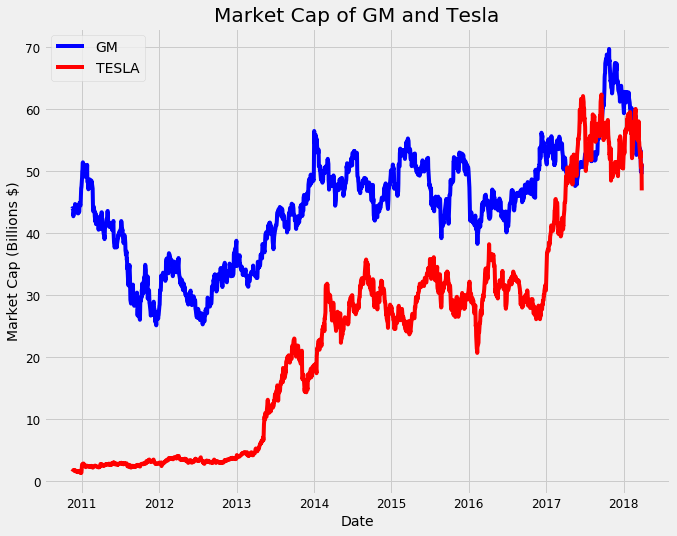

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(cars['Date'], cars['gm_cap'], 'b-', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of GM and Tesla')
plt.legend();

Tesla has had a substantial rise compared to GM, which has had a smaller increase. We can see that between 2017 and 2018 Tesla even passed GM in market cap. 

We can try and find the exact dates where Tesla was valued more than GM. 

In [12]:
import numpy as np

# Find the first and last time Tesla was valued higher than GM
first_date = cars.ix[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.ix[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']

print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23.


C:\Users\notre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


During Q2 2017, Tesla [sold](https://en.wikipedia.org/wiki/Tesla,_Inc.#Production_and_sales) 22026 cars while GM [sold](http://gmauthority.com/blog/gm/general-motors-sales-numbers/) 725000. In Q3 2017, Tesla sold 26137 cars and GM sold 808000. In all of 2017, Tesla sold 103084 cars and GM sold 3002237. That means GM was valued less than Tesla in a year during which it sold 29 times more cars than Tesla! Interesting to say the least.

# Prophet Models

The Facebook Prophet package is designed to analyze time series data with daily observations, which can display patterns on different time scales. 
Prophet is optimized for business tasks with the following characteristics:
- hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- strong multiple “human-scale” seasonalities: day of week and time of year
- important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
- a reasonable number of missing observations or large outliers
- historical trend changes, for instance due to product launches or logging changes
- trends that are non-linear growth curves, where a trend hits a natural limit or saturates

*inspired by https://research.fb.com/prophet-forecasting-at-scale/*

You can install this package on your terminal with the following:
           conda install -c conda-forge fbprophet
           
When "Proceed ([y]/n)?" shows on the terminal, type "y" then click enter

In [28]:
!pip install fbprophet

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [16]:
import fbprophet

# Prophet requires columns ds (Date) and y (value)
gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
gm['y'] = gm['y'] / 1e9

# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
# default changpoint is 0.05, but you can change to 0.15 to control how sensitive the trend is
# higher changepoint = more sensitive
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, daily_seasonality=True)
gm_prophet.fit(gm)

# Repeat for the tesla data
tesla =tesla.rename(columns={'Date': 'ds', 'cap': 'y'})
tesla['y'] = tesla['y'] / 1e9
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, n_changepoints=10, daily_seasonality=True)
tesla_prophet.fit(tesla);

## Effect of Changepoint Prior Scale

If we find that our model is is fitting too closely to our training data (overfitting), our data will not be able to generalize new data.

If our model is not fitting closely enough to our training data (underfitting), our data has too much bias.

Underfitting: increase changepoint to allow more flexibility
Overfitting: decrease changepoint to limit flexibility

In [19]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(tesla)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    tesla[changepoint] = future['yhat']

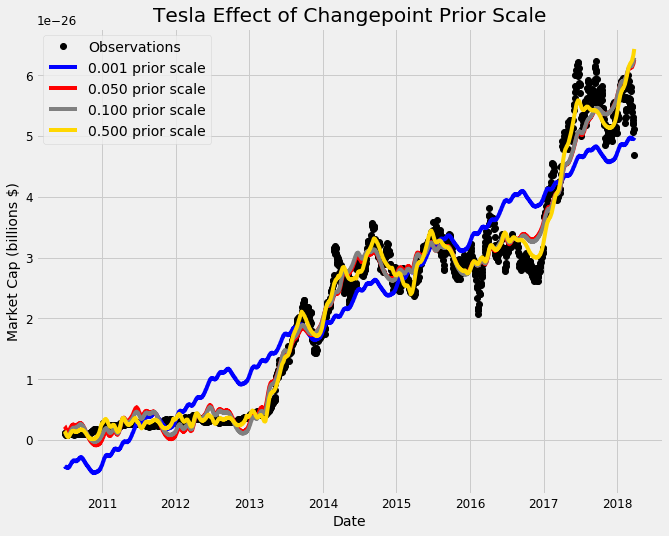

In [20]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(tesla['ds'], tesla['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(tesla['ds'], tesla[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Tesla Effect of Changepoint Prior Scale');

### Predictions for 2 Years

In order to make forecasts, we need to create a future dataframe. We need to specify the amount of future periods to predict and the frequency of our prediction. 

Periods: 2 years
Frequency: Daily

In [24]:
# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

tesla_forecast = tesla_prophet.make_future_dataframe(periods=365*2, freq='D')
tesla_forecast = tesla_prophet.predict(tesla_forecast)

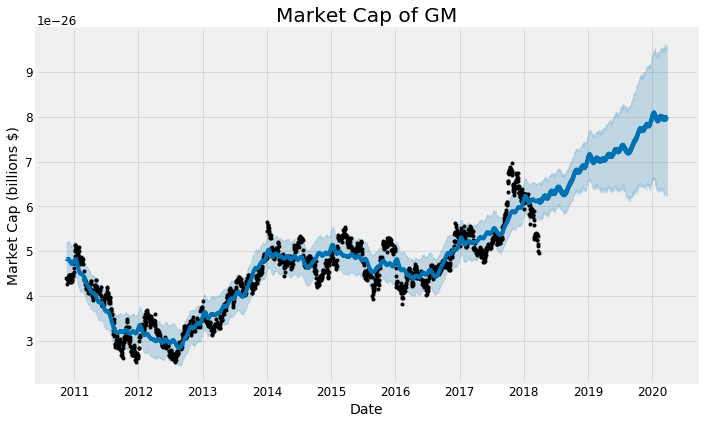

In [25]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GM');

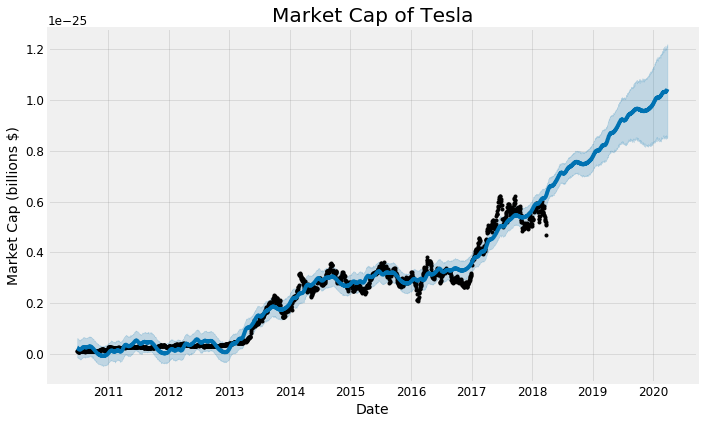

In [26]:
tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Tesla');

The black dots are representing the actual values. They stop in 2018 because that is where our most recent data is from. 

The blue line is representing the forecasted values. 
Notice the blue shaded region. This is our region of uncertainty, which will expand the further into the future we get. This is because it is harder to predict values as time goes on. 

In [21]:
gm_prophet.changepoints[:10]

59    2011-02-14
118   2011-05-10
177   2011-08-03
236   2011-10-26
296   2012-01-24
355   2012-04-18
414   2012-07-12
473   2012-10-04
532   2013-01-02
591   2013-03-28
Name: ds, dtype: datetime64[ns]

In [22]:
tesla_prophet.changepoints[:10]

156    2011-02-09
312    2011-09-22
467    2012-05-04
623    2012-12-18
779    2013-08-02
935    2014-03-18
1091   2014-10-28
1246   2015-06-11
1402   2016-01-25
1558   2016-09-06
Name: ds, dtype: datetime64[ns]

We have listed out the most significant changepoints in our data. This is representing when the time series growth rate significantly changes.

### Do Google searches correlation with changepoints? 

Use data from Google Trends on searches of Tesla to see if there is a connection between searches and the changepoints.

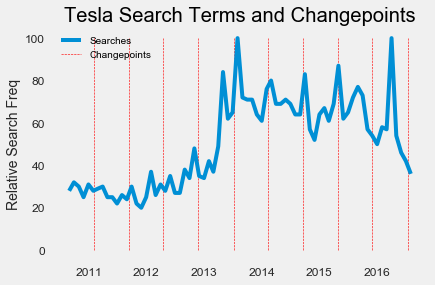

In [20]:
# Load in the data 
tesla_search = pd.read_csv('data/tesla_search_terms.csv')

# Convert month to a datetime
tesla_search['Month'] = pd.to_datetime(tesla_search['Month'])
tesla_changepoints = [str(date) for date in tesla_prophet.changepoints]

# Plot the search frequency
plt.plot(tesla_search['Month'], tesla_search['Search'], label = 'Searches')

# Plot the changepoints
plt.vlines(tesla_changepoints, ymin = 0, ymax= 100, colors = 'r', linewidth=0.6, linestyles = 'dashed', label = 'Changepoints')
plt.grid('off'); plt.ylabel('Relative Search Freq'); plt.legend()
plt.title('Tesla Search Terms and Changepoints');

# Compare Forecasts

We want to determine when Tesla will overtake GM in total market value. We already have the forecasts for two years into the future. We will now join them together and determine when the model predicts Tesla will pull ahead. 

In [21]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]

# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()

# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names

In [22]:
# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')

# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)
forecast.head()

,Date,gm_trend,gm_trend_lower,gm_trend_upper,gm_yhat_lower,gm_yhat_upper,gm_seasonal,gm_seasonal_lower,gm_seasonal_upper,gm_seasonalities,...,tesla_seasonalities,tesla_seasonalities_lower,tesla_seasonalities_upper,tesla_weekly,tesla_weekly_lower,tesla_weekly_upper,tesla_yearly,tesla_yearly_lower,tesla_yearly_upper,tesla_yhat
0,2010-11-18,47.010790,47.010790,47.010790,44.199936,51.794806,0.995675,0.995675,0.995675,0.995675,...,-2.753254,-2.753254,-2.753254,-0.174349,-0.174349,-0.174349,-2.578905,-2.578905,-2.578905,-0.880723
1,2010-11-19,46.968638,46.968638,46.968638,44.296424,51.625326,0.987344,0.987344,0.987344,0.987344,...,-2.806887,-2.806887,-2.806887,-0.199652,-0.199652,-0.199652,-2.607235,-2.607235,-2.607235,-0.924506
2,2010-11-22,46.842182,46.842182,46.842182,44.298147,51.644842,1.165547,1.165547,1.165547,1.165547,...,-2.801310,-2.801310,-2.801310,-0.116490,-0.116490,-0.116490,-2.684820,-2.684820,-2.684820,-0.889382
3,2010-11-23,46.800030,46.800030,46.800030,44.325526,51.718720,1.175756,1.175756,1.175756,1.175756,...,-2.835354,-2.835354,-2.835354,-0.126682,-0.126682,-0.126682,-2.708672,-2.708672,-2.708672,-0.913576
4,2010-11-24,46.757878,46.757878,46.757878,44.363670,51.603003,1.271512,1.271512,1.271512,1.271512,...,-2.857582,-2.857582,-2.857582,-0.125857,-0.125857,-0.125857,-2.731726,-2.731726,-2.731726,-0.925954


### Visualize Trend Only and the Forecast

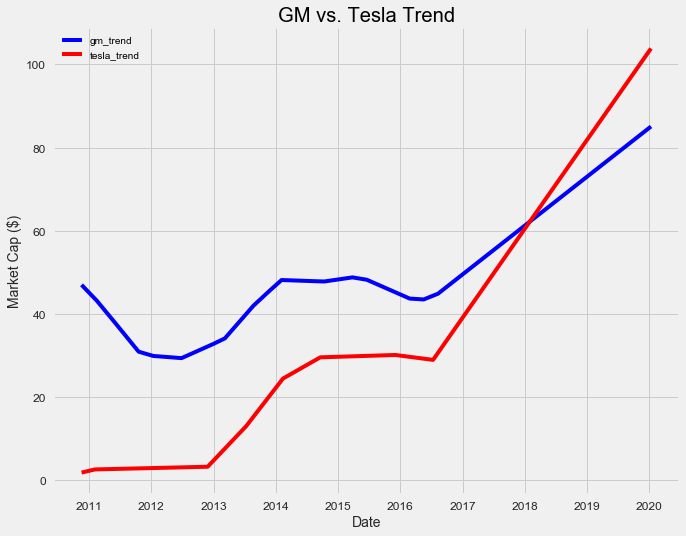

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_trend'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap ($)')
plt.title('GM vs. Tesla Trend'); 

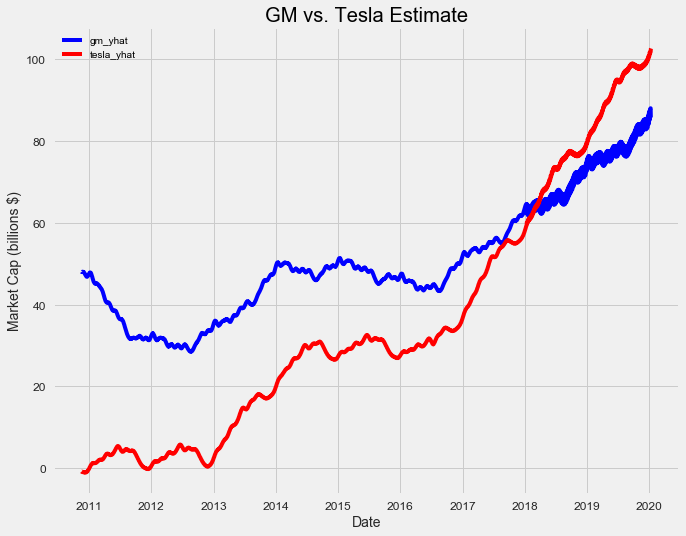

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)')
plt.title('GM vs. Tesla Estimate'); 

In [25]:
overtake_date = min(forecast.ix[forecast['tesla_yhat'] > forecast['gm_yhat'], 'Date'])
print('Tesla overtakes GM on {}'.format(overtake_date))

Tesla overtakes GM on 2018-02-03 00:00:00


## Forecast with Uncertainty Bounds

In [26]:
# Only keep years 2011 onwards and from before 2020
forecast = forecast[forecast['Date'] > '2010-12-31']
forecast = forecast[forecast['Date'] < '2020-01-01']

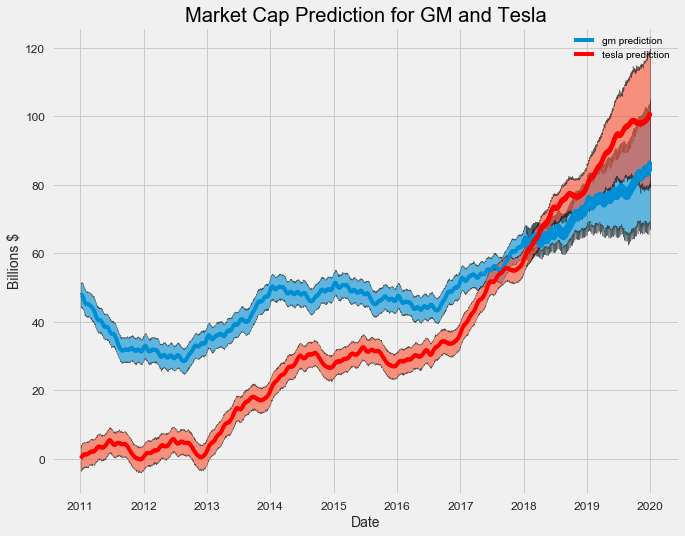

In [27]:
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 8));

# Plot estimate
ax.plot(forecast['Date'], forecast['gm_yhat'], label = 'gm prediction');

# Plot uncertainty values
ax.fill_between(forecast['Date'].dt.to_pydatetime(), forecast['gm_yhat_upper'], forecast['gm_yhat_lower'], alpha=0.6, edgecolor = 'k');

# Plot estimate and uncertainty for tesla
ax.plot(forecast['Date'], forecast['tesla_yhat'], 'r', label = 'tesla prediction');
ax.fill_between(forecast['Date'].dt.to_pydatetime(), forecast['tesla_yhat_upper'], forecast['tesla_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('Market Cap Prediction for GM and Tesla');



## Trends and Patterns

Now, we can use the Prophet Models to inspect different trends in the data. 

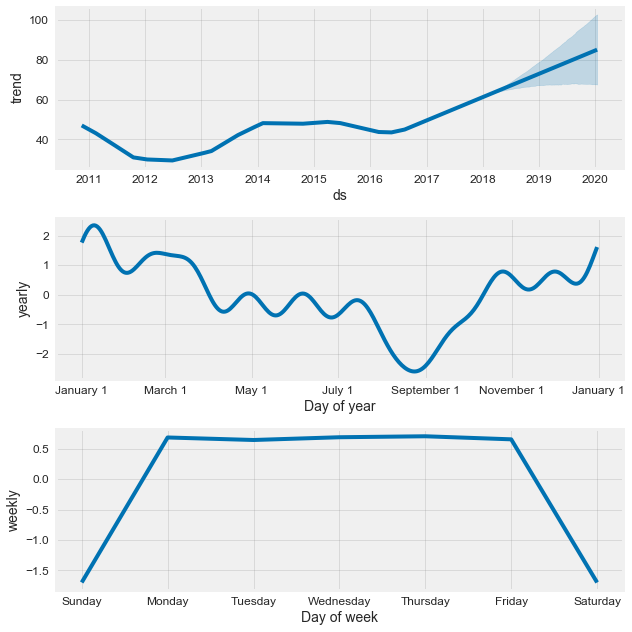

In [28]:
gm_prophet.plot_components(gm_forecast);

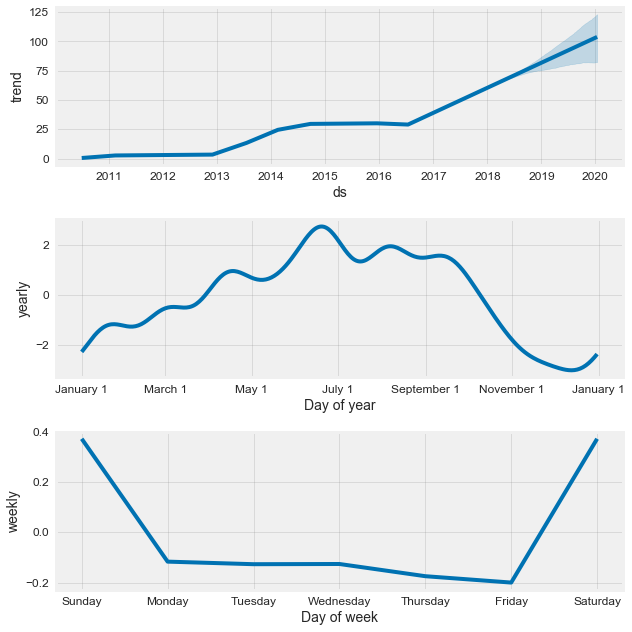

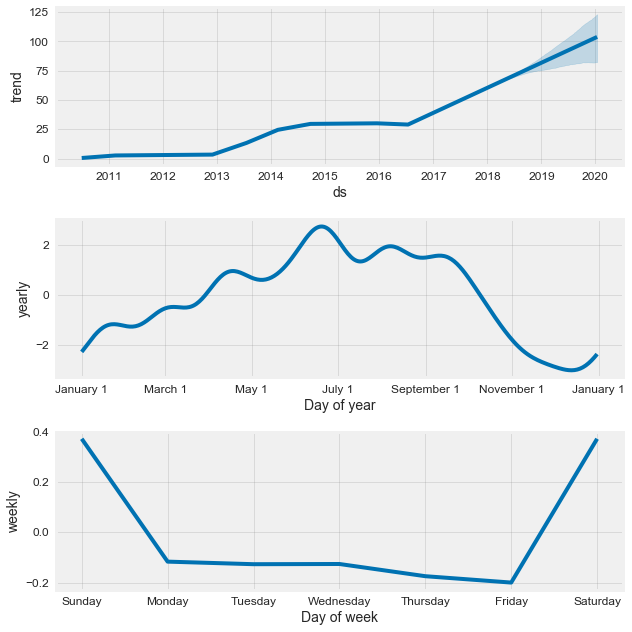

In [29]:
tesla_prophet.plot_components(tesla_forecast)

These graphs show that Tesla tends to increase during the summer, and decrease during the winter, while GM plummets during the summer and increases during the winter. We could compare GM sales with these graphs to see if there is any correlation.

In [30]:
# Read in the sales data
gm_sales = pd.read_csv('data/gm_sales.csv')
gm_sales.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
0,2017,195909,237388,256224,244406,237364,243151,226107,275552,279397,252813,245387,308539,3002237
1,2016,203745,227825,252128,259557,240449,255209,267258,256429,249795,258626,252644,319108,3042773
2,2015,202786,231378,249875,269055,293097,259346,272512,270480,251310,262993,229296,290230,3082358
3,2014,171486,222104,256047,254076,284694,267461,256160,272422,223437,226819,225818,274483,2935007
4,2013,194699,224314,245950,237646,252894,264843,234071,275847,187195,226402,212060,230157,2786078


In [31]:
# Melt the sales data and rename columns
gm_sales = gm_sales.melt(id_vars='Year', var_name = 'Month', value_name = 'Sales')
gm_sales.head(8)

,Year,Month,Sales
0,2017,Jan,195909
1,2016,Jan,203745
2,2015,Jan,202786
3,2014,Jan,171486
4,2013,Jan,194699
5,2012,Jan,167962
6,2011,Jan,178896
7,2010,Jan,145098


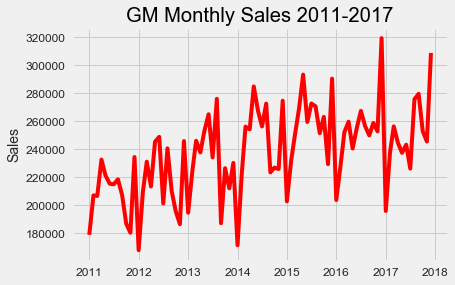

In [32]:
# Format the data for plotting
gm_sales = gm_sales[gm_sales['Month'] != 'Total']
gm_sales = gm_sales[gm_sales['Year'] > 2010]
gm_sales['Date'] = ['-'.join([str(year), month]) for year, month in zip(gm_sales['Year'], gm_sales['Month'])]
gm_sales['Date'] = pd.to_datetime(gm_sales['Date'], format = "%Y-%b")
gm_sales.sort_values(by = 'Date', inplace=True)
gm_sales['Month'] = [date.month for date in gm_sales['Date']]

# Plot the sales over the period
plt.plot(gm_sales['Date'], gm_sales['Sales'], 'r');
plt.title('GM Monthly Sales 2011-2017'); plt.ylabel('Sales');

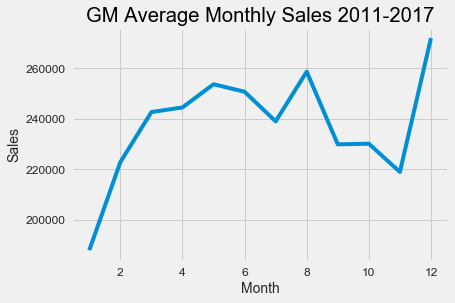

In [33]:
gm_sales_grouped = gm_sales.groupby('Month').mean()
plt.plot(list(range(1, 13)), gm_sales_grouped['Sales']);
plt.xlabel('Month'); plt.ylabel('Sales'); plt.title('GM Average Monthly Sales 2011-2017');

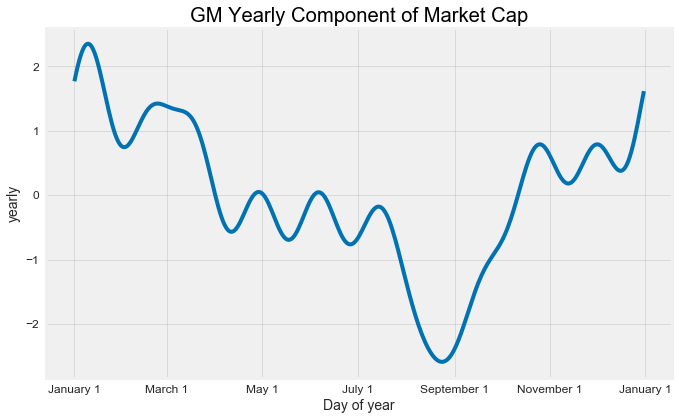

In [34]:
gm_prophet.plot_yearly(); plt.title('GM Yearly Component of Market Cap');

It does not appear as if there is much correlation between market capitalization (a proxy for share price) and sales over the course of a year.

# US vs. China Gross Domestic Product

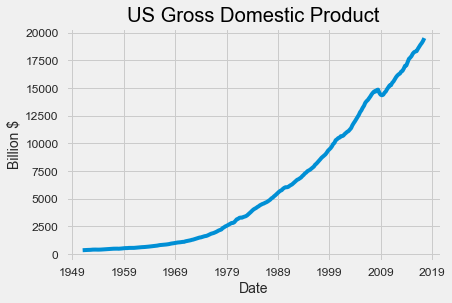

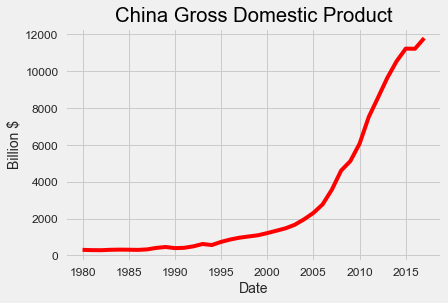

In [35]:
# My personal api key, use your own
quandl.ApiConfig.api_key = 'rFsSehe51RLzREtYhLfo'

# Get data from quandl for US and China GDP
us_gdp = quandl.get('FRED/GDP', collapse='quarterly', start_date = '1950-12-31', end_date='2017-12-31')
china_gdp = quandl.get('ODA/CHN_NGDPD', collapse='yearly', start_date = '1950-12-31', end_date='2017-12-31')

us_gdp.plot(title = 'US Gross Domestic Product', legend=None);
plt.ylabel('Billion $'); 
china_gdp.plot(title = 'China Gross Domestic Product', color = 'r', legend=None);
plt.ylabel('Billion $');

In [36]:
# Change index to date column
us_gdp = us_gdp.reset_index(level=0)
us_gdp.head(5)

,Date,Value
0,1951-03-31,336.372
1,1951-06-30,344.455
2,1951-09-30,351.774
3,1951-12-31,356.579
4,1952-03-31,360.195


In [37]:
china_gdp = china_gdp.reset_index(level=0)
china_gdp.head(5)

,Date,Value
0,1980-12-31,305.350
1,1981-12-31,290.724
2,1982-12-31,286.729
3,1983-12-31,307.683
4,1984-12-31,316.666


In [38]:
# Merge the two gdp data frames and rename columns
gdp = us_gdp.merge(china_gdp, on = 'Date', how = 'left').rename(columns={'Value_x': 'US', 'Value_y': 'China'})
gdp.head(5)

,Date,US,China
0,1951-03-31,336.372,NaN
1,1951-06-30,344.455,NaN
2,1951-09-30,351.774,NaN
3,1951-12-31,356.579,NaN
4,1952-03-31,360.195,NaN


In [39]:
round(gdp.describe(), 2)

,US,China
count,267.00,37.00
mean,6058.74,2739.24
std,5811.22,3484.69
min,336.37,286.73
25%,874.91,411.92
50%,4015.00,1032.58
75%,10490.20,3571.45
max,19500.60,11226.19


In [40]:
# Fill in missing China observations using backward fill
gdp = gdp.fillna(method='bfill')

## Visualize the data

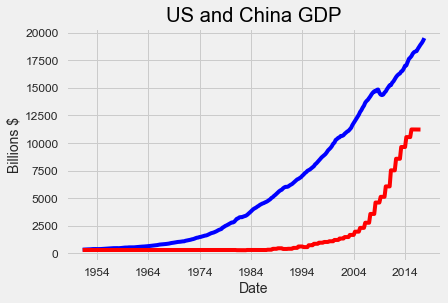

In [41]:
plt.plot(gdp['Date'], gdp['US'], label = 'US', color =  'b')
plt.plot(gdp['Date'], gdp['China'], label = 'China', color = 'r')
plt.ylabel('Billions $'); plt.title('US and China GDP'); plt.xlabel('Date');

## Make Predictions of Future GDP

In [42]:
# Create a prophet object for each dataframe
us_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)
china_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)

# Prophet needs dataframes with a ds (date) and y (variable) column
# Use pandas rename functionality (format is dictionary with {'old': 'new'})
us_gdp = us_gdp.rename(columns={'Date': 'ds', 'Value': 'y'})
china_gdp = china_gdp.rename(columns={'Date': 'ds', 'Value': 'y'})

In [43]:
us_prophet.fit(us_gdp);
china_prophet.fit(china_gdp);

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
us_prophet.changepoints

9     1953-06-30
17    1955-06-30
26    1957-09-30
34    1959-09-30
43    1961-12-31
51    1963-12-31
60    1966-03-31
68    1968-03-31
77    1970-06-30
85    1972-06-30
94    1974-09-30
102   1976-09-30
111   1978-12-31
119   1980-12-31
128   1983-03-31
136   1985-03-31
145   1987-06-30
153   1989-06-30
162   1991-09-30
170   1993-09-30
179   1995-12-31
187   1997-12-31
196   2000-03-31
204   2002-03-31
213   2004-06-30
Name: ds, dtype: datetime64[ns]

### Compare US changepoints to recessions

The prophet object only selects changepoints from the first 80% of the data which is why the recent recession does not appear. We can try and correlate the identified changepoints with actual recessions.

In [45]:
recessions = pd.read_csv('data/recessions.csv', encoding='latin')

In [46]:
recessions[6:]

,name,time,duration,max_unemp,gdp_decline
6,Recession of 196061,Apr 1960  Feb 1961,10 months,7%,2%
7,Recession of 196970,Dec 1969 Nov 1970,11 months,6%,1%
8,197375 recession,Nov 1973  Mar 1975,1 year 4 months,9%,3%
9,1980 recession,JanJuly 1980,6 months,8%,2%
10,19811982 recession,July 1981  Nov 1982,1 year 4 months,11%,3%
11,Early 1990s recession,July 1990  Mar 1991,8 months,8%,1%
12,Early 2000s recession,Mar 2001Nov 2001,8 months,6%,0%
13,Great Recession,Dec 2007  June 2009,1 year 6 months,10%,5%


In [47]:
# Make a future dataframe with 50 years of observations 
# US dataframe and predictions
us_forecast = us_prophet.make_future_dataframe(periods = 50, freq = 'Y')
us_forecast = us_prophet.predict(us_forecast)

# China dataframe and predictions
china_forecast = china_prophet.make_future_dataframe(periods = 50, freq = 'Y')
china_forecast = china_prophet.predict(china_forecast)

## Plot Future Predictions

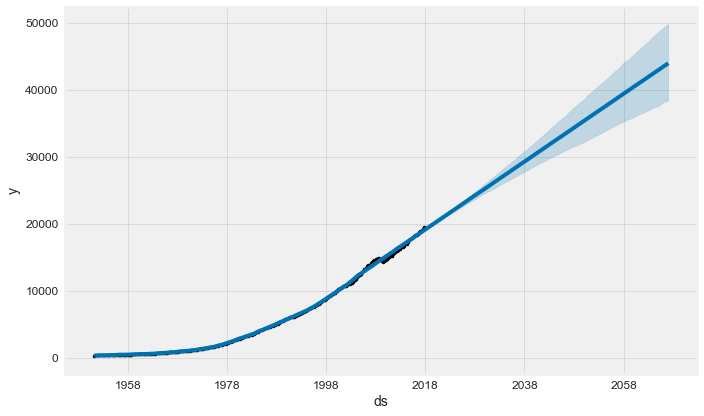

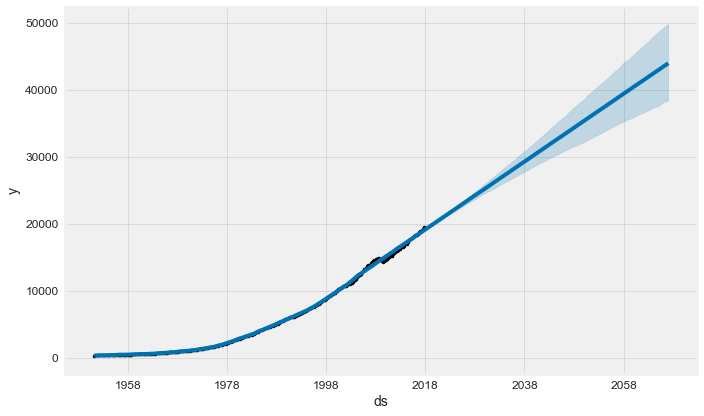

In [48]:
us_prophet.plot(us_forecast)

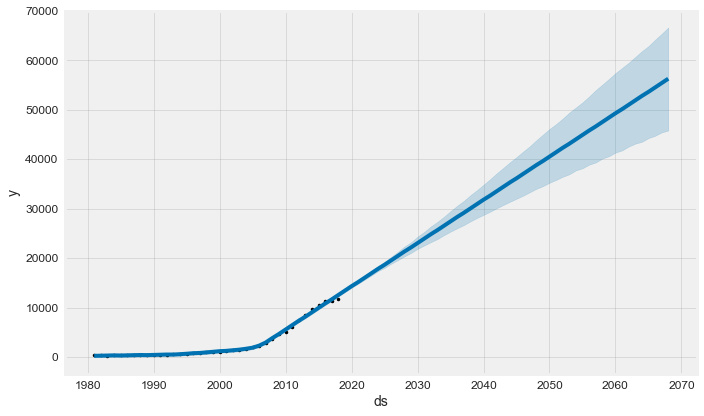

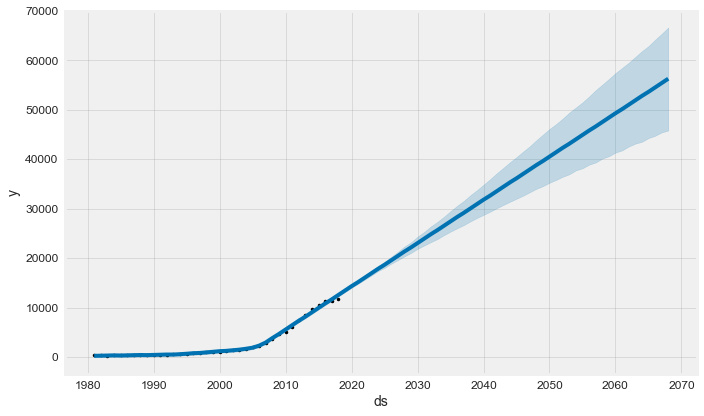

In [49]:
china_prophet.plot(china_forecast)

# When will China Overtake the United States?

In [50]:
us_names = ['us_%s' % column for column in us_forecast.columns]
china_names = ['china_%s' % column for column in china_forecast.columns]

# Dataframes to merge
merge_us_forecast = us_forecast.copy()
merge_china_forecast = china_forecast.copy()

# Rename the columns
merge_us_forecast.columns = us_names
merge_china_forecast.columns = china_names

In [51]:
# Merge the two datasets
gdp_forecast = pd.merge(merge_us_forecast, merge_china_forecast, how = 'inner', left_on = 'us_ds', right_on = 'china_ds')

# Rename date column
gdp_forecast = gdp_forecast.rename(columns={'us_ds': 'Date'}).drop('china_ds', axis=1)
gdp_forecast.head()

,Date,us_trend,us_trend_lower,us_trend_upper,us_yhat_lower,us_yhat_upper,us_seasonal,us_seasonal_lower,us_seasonal_upper,us_seasonalities,...,china_seasonal,china_seasonal_lower,china_seasonal_upper,china_seasonalities,china_seasonalities_lower,china_seasonalities_upper,china_yearly,china_yearly_lower,china_yearly_upper,china_yhat
0,1980-12-31,3833.087377,3833.087377,3833.087377,2756.070455,3176.264583,-861.105061,-861.105061,-861.105061,-861.105061,...,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,223.465825
1,1981-12-31,4093.210971,4093.210971,4093.210971,3010.787584,3450.898403,-860.733951,-860.733951,-860.733951,-860.733951,...,-251.744405,-251.744405,-251.744405,-251.744405,-251.744405,-251.744405,-251.744405,-251.744405,-251.744405,254.714115
2,1982-12-31,4353.334565,4353.334565,4353.334565,3281.809178,3703.796527,-857.883405,-857.883405,-857.883405,-857.883405,...,-237.173828,-237.173828,-237.173828,-237.173828,-237.173828,-237.173828,-237.173828,-237.173828,-237.173828,287.218005
3,1983-12-31,4653.604297,4653.604297,4653.604297,3590.599993,4020.658519,-852.553549,-852.553549,-852.553549,-852.553549,...,-221.365437,-221.365437,-221.365437,-221.365437,-221.365437,-221.365437,-221.365437,-221.365437,-221.365437,320.959709
4,1984-12-31,4967.871419,4967.871419,4967.871419,3892.463860,4326.715660,-861.105061,-861.105061,-861.105061,-861.105061,...,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,-265.059384,295.248206


## Future Plot with Uncertainty

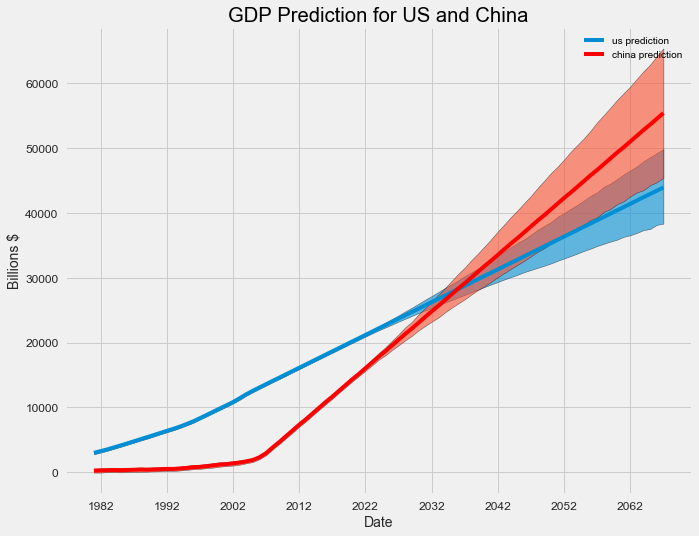

In [52]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8));
ax.plot(gdp_forecast['Date'], gdp_forecast['us_yhat'], label = 'us prediction');
ax.fill_between(gdp_forecast['Date'].dt.to_pydatetime(), gdp_forecast['us_yhat_upper'], gdp_forecast['us_yhat_lower'], alpha=0.6, edgecolor = 'k');
ax.plot(gdp_forecast['Date'], gdp_forecast['china_yhat'], 'r', label = 'china prediction');
ax.fill_between(gdp_forecast['Date'].dt.to_pydatetime(), gdp_forecast['china_yhat_upper'], gdp_forecast['china_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('GDP Prediction for US and China');


In [53]:
first_pass = min(gdp_forecast.ix[gdp_forecast['us_yhat'] < gdp_forecast['china_yhat'], 'Date'])
print('China will overtake the US in GDP on {}.'.format(first_pass))

China will overtake the US in GDP on 2035-12-31 00:00:00.
